# Análise de concorrentes da 5GFlix

## Escopo do Desafio

O novo aplicativo de streaming "5GFlix" está com o desafio de fazer estudos de mercado para formular a estratégia de negócio que irão adotar. 

Para uma parte do estudo de mercado, a "5Gflix" precisa fazer análises em cima de filmes e séries que estão disponíveis na Netflix, a sua concorrente direta.

O CTO da "5Gflix", Alan Turing, entrou em contato com a turma para construir uma estrutura lógica que possibilite que o time de BI da "5GFlix" responda a várias perguntas de negócio relacionadas aos dados da Netflix, detalhadas nos entregáveis deste desafio.

Para poder realizar as análises foi fornecida a seguinte base de dados:

- Base1: https://drive.google.com/file/d/1gLsCjaMrL91ECdThq58cZAzB9tPxG18g/view?usp=sharing
- Base2: https://drive.google.com/file/d/1C_T1w8fc7Oa8MeTo4LMTEcv90IfEOS-6/view?usp=sharing

Vamos utilizar o framework Dask para trabalhar com essas base dados e responder algumas perguntas.

## Carregando bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
import gdown
import os

## Download da base de dados

In [2]:
ROOT_DATA_PATH = '../data'
MOVIES_DATA_PATH = f'{ROOT_DATA_PATH}/movies.csv'
RATINGS_DATA_PATH = f'{ROOT_DATA_PATH}/customers_rating.csv'

In [3]:
movies_url = 'https://drive.google.com/uc?id=1gLsCjaMrL91ECdThq58cZAzB9tPxG18g'
ratings_url = 'https://drive.google.com/uc?id=1C_T1w8fc7Oa8MeTo4LMTEcv90IfEOS-6'

if not os.path.exists(ROOT_DATA_PATH):
    os.makedirs(ROOT_DATA_PATH)
    
if not os.path.isfile(MOVIES_DATA_PATH):
    gdown.download(movies_url, MOVIES_DATA_PATH, quiet=False)

if not os.path.isfile(RATINGS_DATA_PATH):
    gdown.download(ratings_url, RATINGS_DATA_PATH, quiet=False)

## Criando o cluster

In [4]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60734,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.87 GiB
Comm: tcp://127.0.0.1:60753,Total threads: 3
Dashboard: http://127.0.0.1:60755/status,Memory: 3.97 GiB
Nanny: tcp://127.0.0.1:60737,


## Leitura e limpeza dos dados

### Movies dataset (movies_df)

In [5]:
movies_columns = ['movie_id', 'movie_title']
movies_columns

['movie_id', 'movie_title']

In [6]:
movies_df = dd.read_csv(MOVIES_DATA_PATH, delimiter=';', names=movies_columns)
movies_df

,movie_id,movie_title
npartitions=1,,
,int64,string
,...,...


In [7]:
movies_df.head()

,movie_id,movie_title
0,1,"(Dinosaur Planet, 2003)"
1,2,"(Isle of Man TT 2004 Review, 2004)"
2,3,"(Character, 1997)"
3,4,"(Paula Abdul's Get Up & Dance, 1994)"
4,5,"(The Rise and Fall of ECW, 2004)"


Verificando tamanho e tipo de dados do dataset.

In [8]:
print(movies_df.dtypes)

movie_id                 int64
movie_title    string[pyarrow]
dtype: object


In [9]:
print(movies_df.count().compute())

movie_id       4499
movie_title    4499
dtype: int64


Removendo parenteses de `movie_title` para fazer o split do título e ano do filme.

In [10]:
movies_df['movie_title'] = movies_df['movie_title'].str.replace('\(|\)', '', regex=True)
movies_df

,movie_id,movie_title
npartitions=1,,
,int64,string
,...,...


Fazendo split do título e ano em colunas separadas (para facilitar em futuras consultas).

In [11]:
movies_df['title'] = movies_df['movie_title'].str.partition(', ')[0]
movies_df['year'] = movies_df['movie_title'].str.partition(', ')[2]
movies_df = movies_df.drop(columns='movie_title')
movies_df

,movie_id,title,year
npartitions=1,,,
,int64,string,string
,...,...,...


In [12]:
movies_df.head()

,movie_id,title,year
0,1,Dinosaur Planet,2003
1,2,Isle of Man TT 2004 Review,2004
2,3,Character,1997
3,4,Paula Abdul's Get Up & Dance,1994
4,5,The Rise and Fall of ECW,2004


In [13]:
# validando split da coluna movie_title
assert(len(movies_df[(movies_df['title'] == 'Dinosaur Planet') & (movies_df['year'] == '2003')]) == 1)

Verificando valores NA em `movies_df`.

<Figure size 1000x600 with 0 Axes>

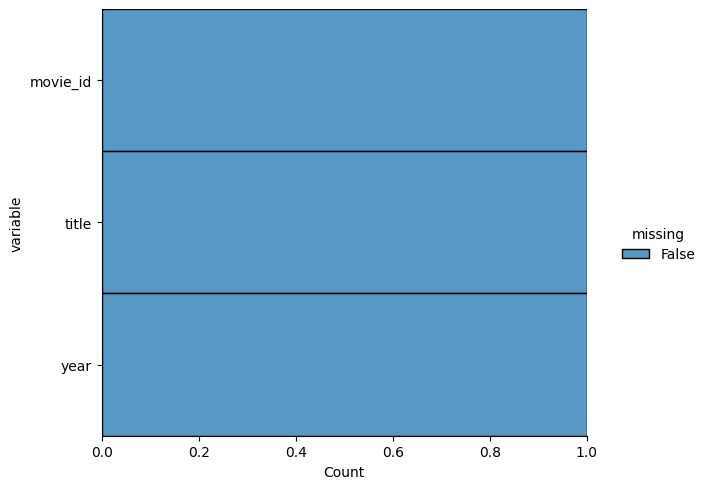

In [14]:
plt.figure(figsize=(10,6))
sns.displot(
    data=movies_df.isna().melt(value_name="missing").compute(),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.show()

Utilizando o `movie_id` como index (para utilizar posteriormente em joins com outras fontes de dados).

In [15]:
movies_df = movies_df.set_index('movie_id').persist()
movies_df

,title,year
npartitions=1,,
1,string,string
4499,...,...


In [16]:
movies_df.head()

,title,year
movie_id,,
1,Dinosaur Planet,2003
2,Isle of Man TT 2004 Review,2004
3,Character,1997
4,Paula Abdul's Get Up & Dance,1994
5,The Rise and Fall of ECW,2004


### Ratings Dataset (ratings_df)

In [17]:
ratings_columns = ['customer_id', 'rating', 'date', 'movie_id']
ratings_columns

['customer_id', 'rating', 'date', 'movie_id']

In [18]:
ratings_df = dd.read_csv(RATINGS_DATA_PATH, delimiter=';')
ratings_df.columns = ratings_columns
ratings_df

,customer_id,rating,date,movie_id
npartitions=10,,,,
,int64,float64,string,int64
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [19]:
ratings_df.head()

,customer_id,rating,date,movie_id
0,1488844,3.0,2005-09-06,1
1,822109,5.0,2005-05-13,1
2,885013,4.0,2005-10-19,1
3,30878,4.0,2005-12-26,1
4,823519,3.0,2004-05-03,1


Verificando tamanho e tipo de dados de `ratings_df`.

In [20]:
print(ratings_df.dtypes)

customer_id              int64
rating                 float64
date           string[pyarrow]
movie_id                 int64
dtype: object


In [21]:
print(ratings_df.count().compute())

customer_id    24053764
rating         24053764
date           24053764
movie_id       24053764
dtype: int64


Verificando valores NA em `ratings_df` (apenas fazendo um count, pois é custoso fazer o distplot deste dataset).

In [22]:
%%time
ratings_df[ratings_df.isna()].count().compute()

CPU times: total: 0 ns
Wall time: 2.06 s


customer_id    0
rating         0
date           0
movie_id       0
dtype: int64

Convertendo date de string para datetime em ratings_df

In [23]:
ratings_df.date = dd.to_datetime(ratings_df.date)
ratings_df.dtypes

customer_id             int64
rating                float64
date           datetime64[ns]
movie_id                int64
dtype: object

In [24]:
ratings_df.head()

,customer_id,rating,date,movie_id
0,1488844,3.0,2005-09-06,1
1,822109,5.0,2005-05-13,1
2,885013,4.0,2005-10-19,1
3,30878,4.0,2005-12-26,1
4,823519,3.0,2004-05-03,1


## Respondendo perguntas sobre os dados

### 1. Quantos filmes estão disponíveis no dataset?

In [25]:
# utilizando o único para garantir que não existem ids duplicados no index
print('Quantidade de filmes disponíveis:', movies_df.index.unique().count().compute())

Quantidade de filmes disponíveis: 4499


### 2. Qual é o nome dos 5 filmes com melhor média de avaliação?

Podemos tirar a média das avaliações agrupando por `movie_id` e utilizar o `nlargest` para obter as 5 maiores médias.

In [26]:
top_5_ratings = ratings_df[['movie_id', 'rating']] \
    .groupby('movie_id') \
    .mean() \
    .nlargest(5, columns='rating') \
    .join(movies_df, how='inner') \
    [['title', 'rating']] \
    .persist()
top_5_ratings

,title,rating
npartitions=1,,
,string,float64
,...,...


In [27]:
%%time
top_5_ratings.compute()

CPU times: total: 15.6 ms
Wall time: 3.64 s


,title,rating
movie_id,,
3456,Lost: Season 1,4.670989
3033,Ghost in the Shell: Stand Alone Complex: 2nd Gig,4.586364
2102,The Simpsons: Season 6,4.581296
4238,Inu-Yasha,4.554434
13,Lord of the Rings: The Return of the King: Ext...,4.552000


### 3. Quais os 9 anos com menos lançamentos de filmes?

Já separamos o ano em uma coluna independente, então podemos contar agrupando por ano e utilizar o `nsmallest` para obter os anos com menos lançamentos.

In [28]:
years = movies_df \
    .groupby('year') \
    .count() \
    ['title'] \
    .rename('count') \
    .nsmallest(9) \
    .compute() \
    .index \
    .sort_values() \
    .tolist()

print('Anos com menos lançamentos:', ", ".join(years))

Anos com menos lançamentos: 1915, 1916, 1917, 1918, 1922, 1924, 1926, 1929, 1931


### 4. Quantos filmes que possuem avaliação maior ou igual a 4.7, considerando apenas os filmes avaliados na última data de avaliação do dataset?

Primeiro vamos obter a última data, executando a função `max` na coluna `date`.

In [29]:
latest_rating_date = ratings_df['date'].max().persist()

Vamos filtrar as avaliações pela data obtida, agrupar por `movie_id` e filtrar apenas os filmes com média maior ou igual a 4.7.

In [30]:
top_rating_movies_in_latest_date = ratings_df \
    [(ratings_df['date'] == latest_rating_date)] \
    [['movie_id', 'rating']] \
    .groupby('movie_id') \
    .mean() \
    .query('rating >= 4.7') \
    .persist()
top_rating_movies_in_latest_date

,rating
npartitions=1,
,float64
,...


Por fim contamos a quantidade de linhas.

In [31]:
count = top_rating_movies_in_latest_date['rating'].count().compute()
date_str = latest_rating_date.compute().strftime("%d/%m/%Y")
print('Filmes com avaliação maior ou igual a 4.7 em %s: %d' % (date_str, count))

Filmes com avaliação maior ou igual a 4.7 em 31/12/2005: 195


### 5. Dos filmes encontrados na questão anterior, quais são os 10 filmes com as piores notas e quais as notas?

Para essa questão, vamos ordenar o resultado obtido na questão anterior para selecionar as 10 piores notas.

In [32]:
top_rating_movies_in_latest_date \
    .nsmallest(10, columns='rating') \
    .join(movies_df, how='inner') \
    [['title', 'year','rating']] \
    .compute()

,title,year,rating
movie_id,,,
3446,Spirited Away,2002,4.714286
1208,The Twilight Zone: Vol. 15,1963,4.750000
1800,An Evening With Kevin Smith,2002,4.750000
1947,Gilmore Girls: Season 3,2002,4.750000
2129,The Twilight Zone: Vol. 41,1960,4.750000
2585,Absolutely Fabulous: Series 2,1994,4.750000
3551,Pete's Dragon,1977,4.750000
4409,SpongeBob SquarePants: Season 3,2002,4.750000
677,In the Mood for Love,2001,4.800000


### 6. Quais os id's dos 5 customers que mais avaliaram filmes e quantas avaliações cada um fez?

Precisamos contar as avaliações por `customer_id` e obter as 5 maiores com `nlargest`.

In [33]:
ratings_df.groupby('customer_id') \
    .count() \
    ['rating'] \
    .rename('count') \
    .nlargest(5) \
    .compute() \
    .reset_index()

,customer_id,count
0,305344,4467
1,387418,4422
2,2439493,4195
3,1664010,4019
4,2118461,3769


In [34]:
# encerrando cluster
cluster.close()
client.close()